## Docker specific configurations

Prepare python path

In [1]:
from sys import path
from pathlib import Path
path.append(str(Path("../../").resolve()))

## Prepare mesh

Generate mesh outside of the docker using the following commands:
```bash
gmsh circle.geo -2
../../tools/convert_msh.py circle.msh circle.xdmf
gmsh ellipse.geo -2
../../tools/convert_msh.py ellipse.msh ellipse.xdmf
```

## Solution preparation

In [2]:
import logging
import bi2d
from bi2d.materials import vacuum, beam, steel
import numpy as np

Using steel for SIBC

In [3]:
beam.index = 1
print(beam)
vacuum.index = 2
print(vacuum)
steel.index = -1
print(steel)

Material(beam)[index=1,eps_r=1.00e+00,sigma=0.00e+00,mu=(1.00e+00, 0.00e+00)]
Material(vacuum)[index=2,eps_r=1.00e+00,sigma=0.00e+00,mu=(1.00e+00, 0.00e+00)]
Material(steel)[index=-1,eps_r=1.00e+00,sigma=1.40e+06,mu=(1.00e+00, 0.00e+00)]


Setup mesh and materials

In [4]:
circle_mesh = bi2d.Mesh("circle.xdmf")
ellipse_mesh = bi2d.Mesh("ellipse.xdmf")
circle_map = bi2d.MaterialMap(circle_mesh, [beam, vacuum])
ellipse_map = bi2d.MaterialMap(ellipse_mesh, [beam, vacuum])

In [5]:
(minx, miny), (maxx, maxy) = circle_mesh.get_limits(1)
print(f"Circle beam radius: {(maxx-minx)/2*1e3} [mm]")
(minx, miny), (maxx, maxy) = circle_mesh.get_limits(2)
print(f"Circle radius: {(maxx-minx)/2*1e3} [mm]")
(minx, miny), (maxx, maxy) = ellipse_mesh.get_limits(1)
print(f"Ellipse beam radius: {(maxx-minx)/2*1e3} [mm]")
(minx, miny), (maxx, maxy) = ellipse_mesh.get_limits(2)
print(f"Ellipse radius: {(maxx-minx)/2*1e3}x{(maxy-miny)/2*1e3} [mm]")

Circle beam radius: 10.0 [mm]
Circle radius: 40.0 [mm]
Ellipse beam radius: 10.0 [mm]
Ellipse radius: 40.0x30.0 [mm]


Configure solution

In [6]:
circle_solution = bi2d.Solution(circle_map, Hcurl_order=2, H1_order=2)
circle_solution.logger.setLevel(logging.INFO)
ellipse_solution = bi2d.Solution(ellipse_map, Hcurl_order=2, H1_order=2)
ellipse_solution.logger.setLevel(logging.INFO)

Monopole sources:

<img src="circle_monopole.png" width="400px"> <img src="ellipse_monopole.png" width="400px">

Dipole sources:

<img src="circle_dipole.png" width="400px"> <img src="ellipse_dipole.png" width="400px">

## Calculate impedance

### Monopole PEC

In [7]:
%%time

circle_data_monopole_pec = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.MONOPOLE)
ellipse_data_monopole_pec = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.MONOPOLE)

INFO:bi2d.solution:Solving for f=1.00e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.74e+05, β=0.50
INFO:bi2d.solution:Solving for f=3.04e+05, β=0.50
INFO:bi2d.solution:Solving for f=5.30e+05, β=0.50
INFO:bi2d.solution:Solving for f=9.24e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.61e+06, β=0.50
INFO:bi2d.solution:Solving for f=2.81e+06, β=0.50
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.50
INFO:bi2d.solution:Solving for f=8.53e+06, β=0.50
INFO:bi2d.solution:Solving for f=1.49e+07, β=0.50
INFO:bi2d.solution:Solving for f=2.59e+07, β=0.50
INFO:bi2d.solution:Solving for f=4.52e+07, β=0.50
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.50
INFO:bi2d.solution:Solving for f=1.37e+08, β=0.50
INFO:bi2d.solution:Solving for f=2.40e+08, β=0.50
INFO:bi2d.solution:Solving for f=4.18e+08, β=0.50
INFO:bi2d.solution:Solving for f=7.28e+08, β=0.50
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.50
INFO:bi2d.solution:Solving for f=2.21e+09, β=0.50
INFO:bi2d.solution:Solving for f=3.86e+09, β=0.50


CPU times: user 1min 29s, sys: 2.73 s, total: 1min 32s
Wall time: 1min 31s


In [8]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

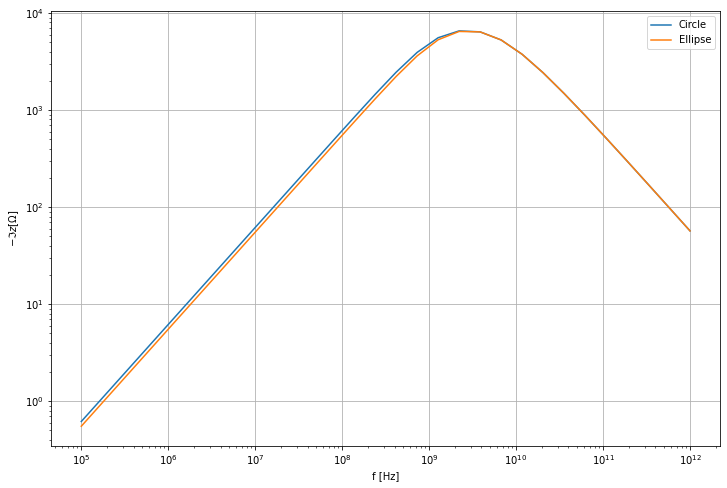

In [9]:
pylab.plot(circle_data_monopole_pec[:,0], -circle_data_monopole_pec[:,2])
pylab.plot(ellipse_data_monopole_pec[:,0], -ellipse_data_monopole_pec[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$-\Im{z} [\Omega]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

### Monopole SIBC

In [10]:
%%time

circle_data_monopole_sibc = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[steel])
ellipse_data_monopole_sibc = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[steel])

INFO:bi2d.solution:Solving for f=1.00e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.74e+05, β=0.50
INFO:bi2d.solution:Solving for f=3.04e+05, β=0.50
INFO:bi2d.solution:Solving for f=5.30e+05, β=0.50
INFO:bi2d.solution:Solving for f=9.24e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.61e+06, β=0.50
INFO:bi2d.solution:Solving for f=2.81e+06, β=0.50
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.50
INFO:bi2d.solution:Solving for f=8.53e+06, β=0.50
INFO:bi2d.solution:Solving for f=1.49e+07, β=0.50
INFO:bi2d.solution:Solving for f=2.59e+07, β=0.50
INFO:bi2d.solution:Solving for f=4.52e+07, β=0.50
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.50
INFO:bi2d.solution:Solving for f=1.37e+08, β=0.50
INFO:bi2d.solution:Solving for f=2.40e+08, β=0.50
INFO:bi2d.solution:Solving for f=4.18e+08, β=0.50
INFO:bi2d.solution:Solving for f=7.28e+08, β=0.50
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.50
INFO:bi2d.solution:Solving for f=2.21e+09, β=0.50
INFO:bi2d.solution:Solving for f=3.86e+09, β=0.50


CPU times: user 1min 29s, sys: 2.72 s, total: 1min 32s
Wall time: 1min 32s


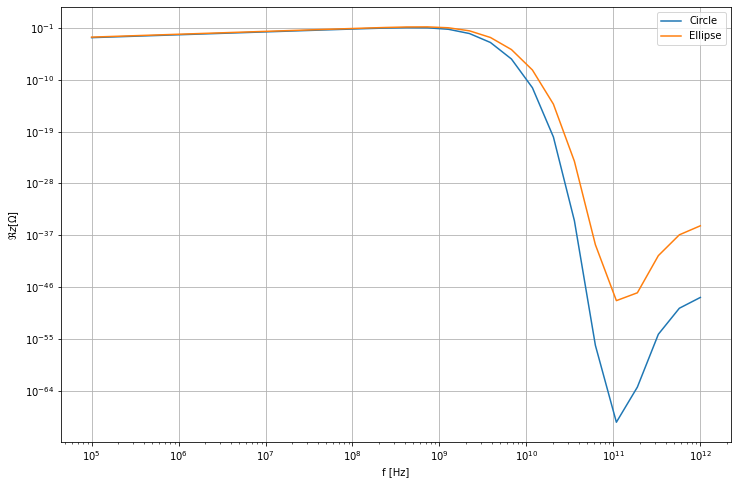

In [11]:
pylab.plot(circle_data_monopole_sibc[:,0], circle_data_monopole_sibc[:,1])
pylab.plot(ellipse_data_monopole_sibc[:,0], ellipse_data_monopole_sibc[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$\Re{z} [\Omega]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

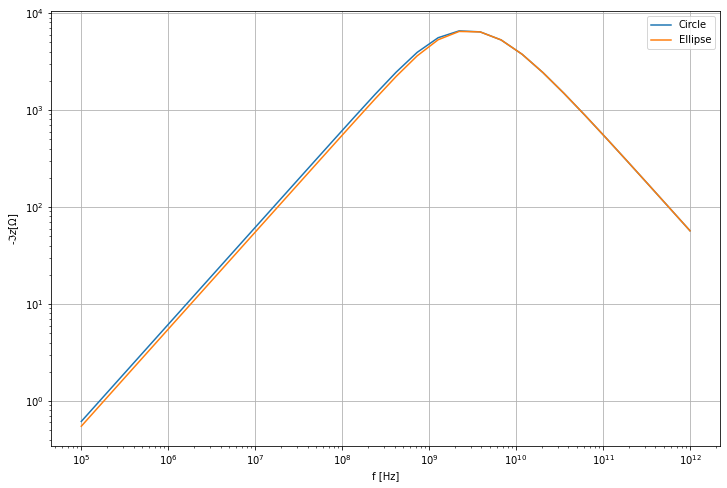

In [12]:
pylab.plot(circle_data_monopole_sibc[:,0], -circle_data_monopole_sibc[:,2])
pylab.plot(ellipse_data_monopole_sibc[:,0], -ellipse_data_monopole_sibc[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"-$\Im{z} [\Omega]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

### Dipole PEC rotation $0$

In [13]:
%%time

circle_data_dipole_pec_0 = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, rotation=0, source_function=bi2d.SourceFunction.DIPOLE)
ellipse_data_dipole_pec_0 = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, rotation=0, source_function=bi2d.SourceFunction.DIPOLE)

INFO:bi2d.solution:Solving for f=1.00e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.74e+05, β=0.50
INFO:bi2d.solution:Solving for f=3.04e+05, β=0.50
INFO:bi2d.solution:Solving for f=5.30e+05, β=0.50
INFO:bi2d.solution:Solving for f=9.24e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.61e+06, β=0.50
INFO:bi2d.solution:Solving for f=2.81e+06, β=0.50
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.50
INFO:bi2d.solution:Solving for f=8.53e+06, β=0.50
INFO:bi2d.solution:Solving for f=1.49e+07, β=0.50
INFO:bi2d.solution:Solving for f=2.59e+07, β=0.50
INFO:bi2d.solution:Solving for f=4.52e+07, β=0.50
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.50
INFO:bi2d.solution:Solving for f=1.37e+08, β=0.50
INFO:bi2d.solution:Solving for f=2.40e+08, β=0.50
INFO:bi2d.solution:Solving for f=4.18e+08, β=0.50
INFO:bi2d.solution:Solving for f=7.28e+08, β=0.50
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.50
INFO:bi2d.solution:Solving for f=2.21e+09, β=0.50
INFO:bi2d.solution:Solving for f=3.86e+09, β=0.50


CPU times: user 1min 45s, sys: 3.05 s, total: 1min 48s
Wall time: 1min 48s


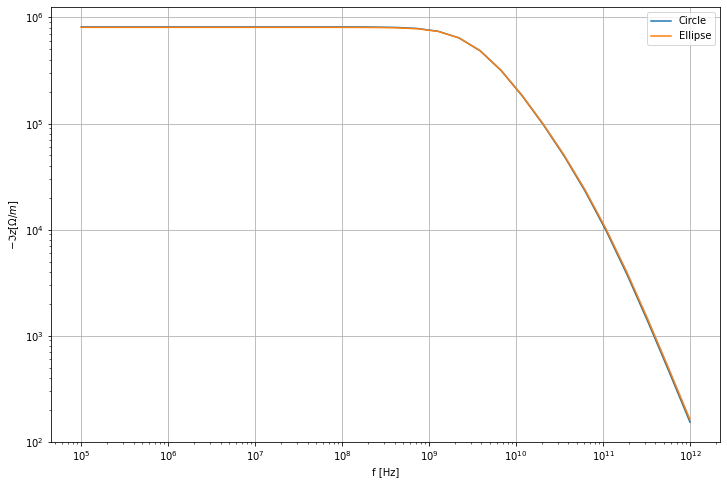

In [14]:
pylab.plot(circle_data_dipole_pec_0[:,0], -circle_data_dipole_pec_0[:,2])
pylab.plot(ellipse_data_dipole_pec_0[:,0], -ellipse_data_dipole_pec_0[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$-\Im{z} [\Omega/m]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

### Dipole PEC rotation $90^\circ$

In [15]:
%%time

circle_data_dipole_pec_90 = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE)
ellipse_data_dipole_pec_90 = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE)

INFO:bi2d.solution:Solving for f=1.00e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.74e+05, β=0.50
INFO:bi2d.solution:Solving for f=3.04e+05, β=0.50
INFO:bi2d.solution:Solving for f=5.30e+05, β=0.50
INFO:bi2d.solution:Solving for f=9.24e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.61e+06, β=0.50
INFO:bi2d.solution:Solving for f=2.81e+06, β=0.50
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.50
INFO:bi2d.solution:Solving for f=8.53e+06, β=0.50
INFO:bi2d.solution:Solving for f=1.49e+07, β=0.50
INFO:bi2d.solution:Solving for f=2.59e+07, β=0.50
INFO:bi2d.solution:Solving for f=4.52e+07, β=0.50
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.50
INFO:bi2d.solution:Solving for f=1.37e+08, β=0.50
INFO:bi2d.solution:Solving for f=2.40e+08, β=0.50
INFO:bi2d.solution:Solving for f=4.18e+08, β=0.50
INFO:bi2d.solution:Solving for f=7.28e+08, β=0.50
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.50
INFO:bi2d.solution:Solving for f=2.21e+09, β=0.50
INFO:bi2d.solution:Solving for f=3.86e+09, β=0.50


CPU times: user 2min 10s, sys: 4.02 s, total: 2min 14s
Wall time: 2min 17s


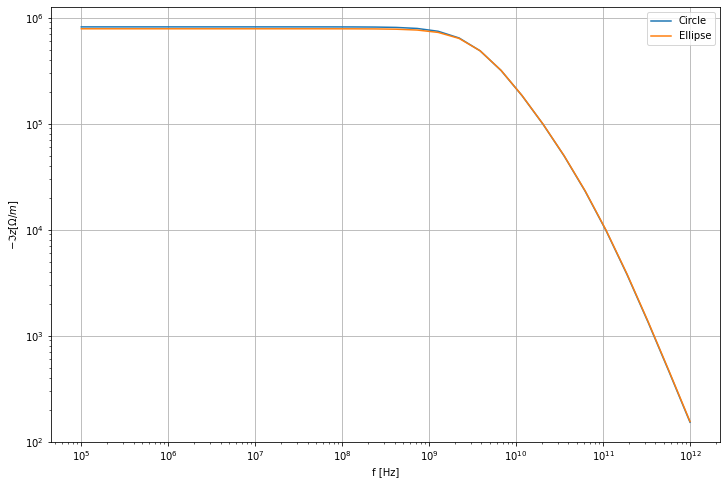

In [16]:
pylab.plot(circle_data_dipole_pec_90[:,0], -circle_data_dipole_pec_90[:,2])
pylab.plot(ellipse_data_dipole_pec_90[:,0], -ellipse_data_dipole_pec_90[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$-\Im{z} [\Omega/m]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

### Dipole SIBC rotation 0

In [17]:
%%time

circle_data_dipole_sibc_0 = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.DIPOLE, sibc=[steel])
ellipse_data_dipole_sibc_0 = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.DIPOLE, sibc=[steel])

INFO:bi2d.solution:Solving for f=1.00e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.74e+05, β=0.50
INFO:bi2d.solution:Solving for f=3.04e+05, β=0.50
INFO:bi2d.solution:Solving for f=5.30e+05, β=0.50
INFO:bi2d.solution:Solving for f=9.24e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.61e+06, β=0.50
INFO:bi2d.solution:Solving for f=2.81e+06, β=0.50
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.50
INFO:bi2d.solution:Solving for f=8.53e+06, β=0.50
INFO:bi2d.solution:Solving for f=1.49e+07, β=0.50
INFO:bi2d.solution:Solving for f=2.59e+07, β=0.50
INFO:bi2d.solution:Solving for f=4.52e+07, β=0.50
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.50
INFO:bi2d.solution:Solving for f=1.37e+08, β=0.50
INFO:bi2d.solution:Solving for f=2.40e+08, β=0.50
INFO:bi2d.solution:Solving for f=4.18e+08, β=0.50
INFO:bi2d.solution:Solving for f=7.28e+08, β=0.50
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.50
INFO:bi2d.solution:Solving for f=2.21e+09, β=0.50
INFO:bi2d.solution:Solving for f=3.86e+09, β=0.50


CPU times: user 1min 59s, sys: 3.99 s, total: 2min 3s
Wall time: 2min 35s


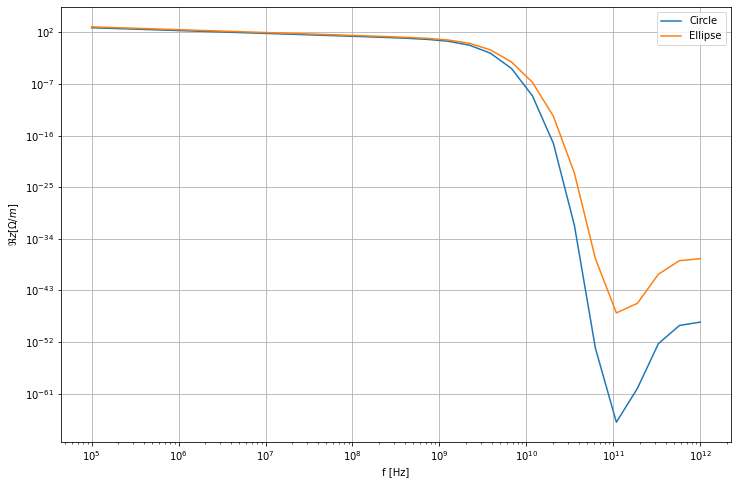

In [18]:
pylab.plot(circle_data_dipole_sibc_0[:,0], circle_data_dipole_sibc_0[:,1])
pylab.plot(ellipse_data_dipole_sibc_0[:,0], ellipse_data_dipole_sibc_0[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$\Re{z} [\Omega/m]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

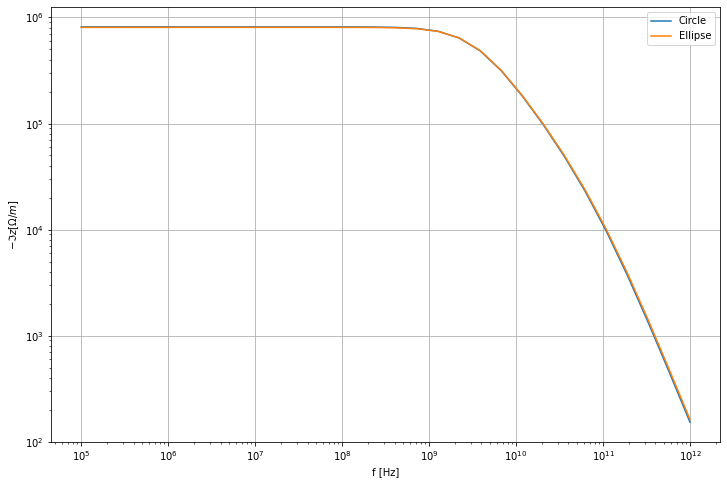

In [19]:
pylab.plot(circle_data_dipole_sibc_0[:,0], -circle_data_dipole_sibc_0[:,2])
pylab.plot(ellipse_data_dipole_sibc_0[:,0], -ellipse_data_dipole_sibc_0[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$-\Im{z} [\Omega/m]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

### Dipole SIBC rotation $90^\circ$

In [20]:
%%time

circle_data_dipole_sibc_90 = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE, sibc=[steel])
ellipse_data_dipole_sibc_90 = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, rotation=np.pi/2, source_function=bi2d.SourceFunction.DIPOLE, sibc=[steel])

INFO:bi2d.solution:Solving for f=1.00e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.74e+05, β=0.50
INFO:bi2d.solution:Solving for f=3.04e+05, β=0.50
INFO:bi2d.solution:Solving for f=5.30e+05, β=0.50
INFO:bi2d.solution:Solving for f=9.24e+05, β=0.50
INFO:bi2d.solution:Solving for f=1.61e+06, β=0.50
INFO:bi2d.solution:Solving for f=2.81e+06, β=0.50
INFO:bi2d.solution:Solving for f=4.89e+06, β=0.50
INFO:bi2d.solution:Solving for f=8.53e+06, β=0.50
INFO:bi2d.solution:Solving for f=1.49e+07, β=0.50
INFO:bi2d.solution:Solving for f=2.59e+07, β=0.50
INFO:bi2d.solution:Solving for f=4.52e+07, β=0.50
INFO:bi2d.solution:Solving for f=7.88e+07, β=0.50
INFO:bi2d.solution:Solving for f=1.37e+08, β=0.50
INFO:bi2d.solution:Solving for f=2.40e+08, β=0.50
INFO:bi2d.solution:Solving for f=4.18e+08, β=0.50
INFO:bi2d.solution:Solving for f=7.28e+08, β=0.50
INFO:bi2d.solution:Solving for f=1.27e+09, β=0.50
INFO:bi2d.solution:Solving for f=2.21e+09, β=0.50
INFO:bi2d.solution:Solving for f=3.86e+09, β=0.50


CPU times: user 1min 35s, sys: 3.36 s, total: 1min 38s
Wall time: 2min 4s


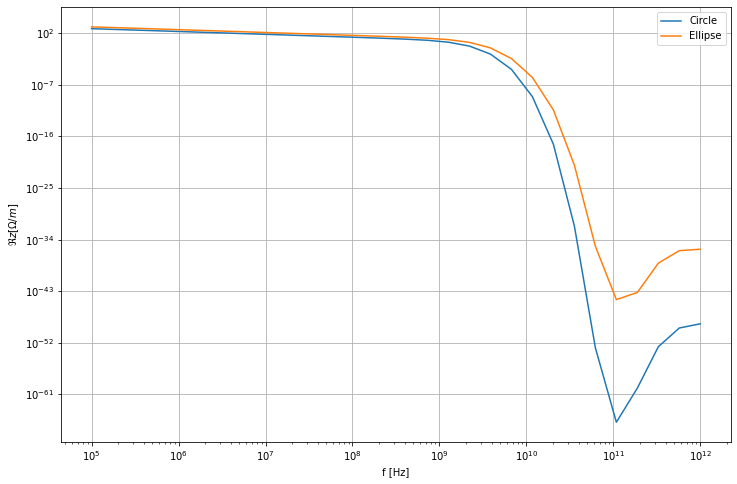

In [21]:
pylab.plot(circle_data_dipole_sibc_90[:,0], circle_data_dipole_sibc_90[:,1])
pylab.plot(ellipse_data_dipole_sibc_90[:,0], ellipse_data_dipole_sibc_90[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$\Re{z} [\Omega/m]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

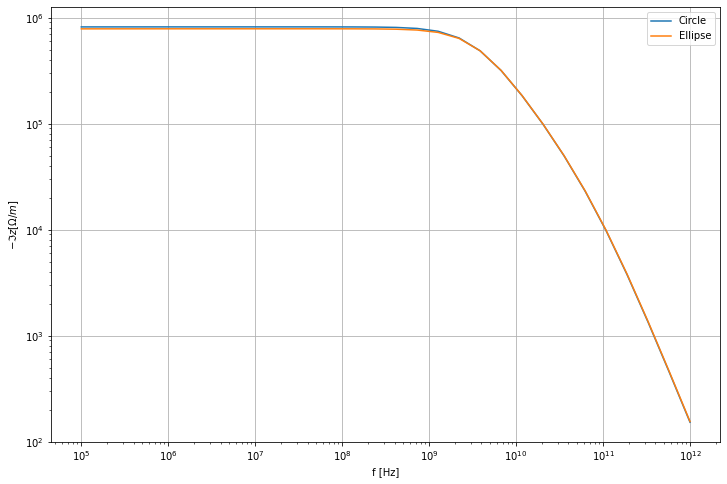

In [22]:
pylab.plot(circle_data_dipole_sibc_90[:,0], -circle_data_dipole_sibc_90[:,2])
pylab.plot(ellipse_data_dipole_sibc_90[:,0], -ellipse_data_dipole_sibc_90[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f [Hz]")
pylab.ylabel(r"$-\Im{z} [\Omega/m]$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()